In [1]:
#Add new directory to path to import ngs and pserm
import sys
import os
path = os.getcwd()
path_with_ngs_and_pserm = os.path.dirname(os.path.dirname(path))

sys.path.append(path_with_ngs_and_pserm)

#Imports 
import tqdm
import glob
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from ngs import NGS_round_data, NGS_DMD, common_clones
from pserm import ngs_analysis, generate_clone_set
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import spearmanr, pearsonr

#specify font properties for better export into adobe illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#Add myriad pro font
fpath = "/Library/Fonts/Myriad Pro Regular.ttf"
aapath = '/Library/Fonts/cour.ttf'

prop = fm.FontProperties(fname=fpath, size = 20)
tickprop = fm.FontProperties(fname = fpath, size = 16)
aaprop = fm.FontProperties(fname = aapath, size = 16)

chemistry = {
    'A': 'black',
    'C': 'green',
    'D': 'red',
    'E': 'red',
    'F': 'black',
    'G': 'green',
    'H': 'blue',
    'I': 'black',
    'K': 'blue',
    'L': 'black',
    'M': 'black',
    'N': 'purple',
    'P': 'black',
    'Q': 'purple',
    'R': 'blue',
    'S': 'green',
    'T': 'green',
    'V': 'black',
    'W': 'black',
    'Y': 'green'
}

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
NGS package imported


In [2]:
p1_wt = 'YRRRGAWY'

p1_muts_no_wt = {
0: ['A', 'D', 'F', 'S', 'V'],
1: ['A', 'E', 'G', 'K', 'T'],
2: ['A', 'E', 'G', 'K', 'T'],
3: ['A', 'E', 'G', 'K', 'T'],
4: ['A', 'D', 'N', 'S', 'T'],
5: ['D', 'F', 'S', 'V', 'Y'],
6: ['L', 'G', 'V', 'S', 'A'],
7: ['A', 'D', 'F', 'S', 'V']
}

p1_r1 = NGS_round_data(
    Round = 3, 
    sequence_type = 'mutations', 
    samples =[
        'Input', 'Ag1_P', 'Ag01_P', 'DA_P', 'PSR_P', 'PSR_N', 
        'Ins_P', 'Ins_N', 'Ova_P', 'Ova_N'],
    sample_of_interest = 'Input', 
    path = '../Input_Datasets/Project_1/Rep_1', 
    wild_type = p1_wt, 
    mutations_dict = p1_muts_no_wt
)

p1_r2 = NGS_round_data(
    Round = 3, 
    sequence_type = 'mutations', 
    samples =[
        'Input', 'Ag1_P', 'Ag01_P', 'DA_P', 'PSR_P', 'PSR_N', 'PSR_NB', 
        'Ins_P', 'Ins_NS', 'Ins_NB', 'Ova_P', 'Ova_N', 'Ova_NB'],
    sample_of_interest = 'Input', 
    path = '../Input_Datasets/Project_1/Rep_2', 
    wild_type = p1_wt, 
    mutations_dict = p1_muts_no_wt
)

p1_clone_set_trimmed_r1 = generate_clone_set(p1_r1, ['Input', 'Ag1_P', 'Ag01_P', 'PSR_P', 'PSR_N', 'Ova_P', 'Ova_N', 'Ins_P'])
p1_clone_set_trimmed_r2 = generate_clone_set(p1_r2, ['Input', 'Ag1_P', 'Ag01_P', 'PSR_P', 'PSR_N', 'Ova_P', 'Ova_N', 'Ins_P'])
p1_clone_set_trimmed = list(set(p1_clone_set_trimmed_r1).union(set(p1_clone_set_trimmed_r2)))

p1_data = ngs_analysis([p1_r1, p1_r2], ['Input', 'Ag1_P', 'Ag01_P', 'PSR_P', 'PSR_N', 'Ova_P', 'Ova_N'], clone_set = p1_clone_set_trimmed)

p1_data.generate_D()

for pssm in glob.glob('../Project_PSSMs/Project_1/*.xlsx'):
    p1_data.load_pssm(pssm.split('.xlsx')[0].split('/')[-1], pssm, excel_or_csv = 'excel')

for ppm in glob.glob('../Project_PPMs/Project_1/*.xlsx'):    
    p1_data.load_ppm(ppm.split('.xlsx')[0].split('/')[-1], ppm, excel_or_csv = 'excel')

for sample in p1_data.samples:
    if sample != 'Input':
        p1_data.generate_PSERM(In_sample = 'Input', Out_sample = sample)


['Mutation_139624.csv', 'Mutation_139625.csv', 'Mutation_139626.csv', 'Mutation_139627.csv', 'Mutation_139628.csv', 'Mutation_139629.csv', 'Mutation_139630.csv', 'Mutation_139631.csv', 'Mutation_139632.csv', 'Mutation_139633.csv']


['Mutation_140403.csv', 'Mutation_140404.csv', 'Mutation_140405.csv', 'Mutation_140406.csv', 'Mutation_140407.csv', 'Mutation_140408.csv', 'Mutation_140409.csv', 'Mutation_140410.csv', 'Mutation_140411.csv', 'Mutation_140412.csv', 'Mutation_140413.csv', 'Mutation_140414.csv', 'Mutation_140415.csv']


100%|██████████| 774931/774931 [00:01<00:00, 513961.10it/s]


## Create fixed residue PSSM

In [3]:
for pos, aalist in tqdm.tqdm(p1_data.library.items()):
    for aa in aalist:
        p1_data.generate_fixed_resi_PSSM('Input', pos, aa)
        p1_data.generate_fixed_resi_PSSM('Ag01_P', pos, aa)
        p1_data.generate_fixed_resi_PSSM('Ova_P', pos, aa)
        p1_data.generate_fixed_resi_PSSM('PSR_P', pos, aa)
        p1_data.generate_fixed_resi_PSSM('Ag1_P', pos, aa)
        p1_data.generate_fixed_resi_PSSM('Ova_N', pos, aa)
        p1_data.generate_fixed_resi_PSSM('PSR_N', pos, aa)

        p1_data.generate_PSERM(In_sample = f'{pos}_{aa}_Input', Out_sample = f'{pos}_{aa}_Ag01_P')
        p1_data.generate_PSERM(In_sample = f'{pos}_{aa}_Input', Out_sample = f'{pos}_{aa}_Ova_P')
        p1_data.generate_PSERM(In_sample = f'{pos}_{aa}_Input', Out_sample = f'{pos}_{aa}_PSR_P')
        p1_data.generate_PSERM(In_sample = f'{pos}_{aa}_Input', Out_sample = f'{pos}_{aa}_Ag1_P')
        p1_data.generate_PSERM(In_sample = f'{pos}_{aa}_Input', Out_sample = f'{pos}_{aa}_Ova_N')
        p1_data.generate_PSERM(In_sample = f'{pos}_{aa}_Input', Out_sample = f'{pos}_{aa}_PSR_N')

100%|██████████| 1229763/1229763 [00:03<00:00, 385225.26it/s]


Generating MSA.


100%|██████████| 8/8 [40:25<00:00, 303.19s/it]


In [4]:
for pos, aalist in p1_data.library.items():
    for aa in aalist:
        p1_data.PSSM[f'{pos}_{aa}_Input'].to_excel(f'../Project_PSSMs/Project_1/Fixed_Residue_PSSM/{pos}_{aa}_Input.xlsx')
        p1_data.PSSM[f'{pos}_{aa}_Ag01_P'].to_excel(f'../Project_PSSMs/Project_1/Fixed_Residue_PSSM/{pos}_{aa}_Ag01_P.xlsx')
        p1_data.PSSM[f'{pos}_{aa}_Ag1_P'].to_excel(f'../Project_PSSMs/Project_1/Fixed_Residue_PSSM/{pos}_{aa}_Ag1_P.xlsx')
        p1_data.PSSM[f'{pos}_{aa}_Ova_P'].to_excel(f'../Project_PSSMs/Project_1/Fixed_Residue_PSSM/{pos}_{aa}_Ova_P.xlsx')
        p1_data.PSSM[f'{pos}_{aa}_Ova_N'].to_excel(f'../Project_PSSMs/Project_1/Fixed_Residue_PSSM/{pos}_{aa}_Ova_N.xlsx')
        p1_data.PSSM[f'{pos}_{aa}_PSR_P'].to_excel(f'../Project_PSSMs/Project_1/Fixed_Residue_PSSM/{pos}_{aa}_PSR_P.xlsx')
        p1_data.PSSM[f'{pos}_{aa}_PSR_N'].to_excel(f'../Project_PSSMs/Project_1/Fixed_Residue_PSSM/{pos}_{aa}_PSR_N.xlsx')

# Load fixed residue PSSM

In [3]:
for pssm in glob.glob('../Project_PSSMs/Project_1/Fixed_Residue_PSSM/*.xlsx'):
    p1_data.load_pssm(pssm.split('.xlsx')[0].split('/')[-1], pssm, excel_or_csv = 'excel')

for pos, aalist in tqdm.tqdm(p1_data.library.items()):
    for aa in aalist:
        p1_data.generate_PSERM(In_sample = f'{pos}_{aa}_Input', Out_sample = f'{pos}_{aa}_Ag01_P')
        p1_data.generate_PSERM(In_sample = f'{pos}_{aa}_Input', Out_sample = f'{pos}_{aa}_Ag1_P')
        p1_data.generate_PSERM(In_sample = f'{pos}_{aa}_Input', Out_sample = f'{pos}_{aa}_Ova_P')
        p1_data.generate_PSERM(In_sample = f'{pos}_{aa}_Input', Out_sample = f'{pos}_{aa}_PSR_P')

100%|██████████| 8/8 [00:00<00:00, 393.47it/s]


In [10]:
p1_data.get_all_mut_JS_divergence_matrix('Ag01_P')
#p1_data.get_all_mut_JS_divergence_matrix('Ag1_P')
p1_data.get_all_mut_JS_divergence_matrix('Ova_P')
#p1_data.get_all_mut_JS_divergence_matrix('PSR_P')
#p1_data.get_all_mut_JS_divergence_matrix('Ova_N')
#p1_data.get_all_mut_JS_divergence_matrix('PSR_N')

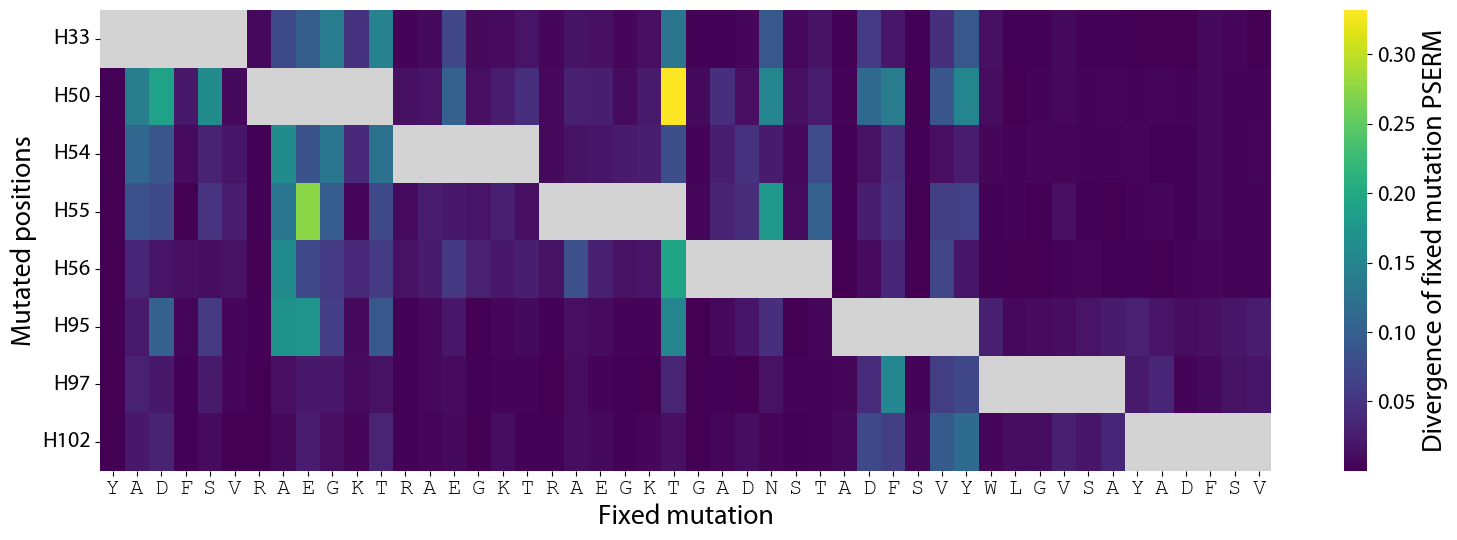

In [5]:
fig, ax = plt.subplots(figsize = (7.2 *2.2, 5.5))
############# Plot Heatmap of DJS ####################
ag_mask = np.zeros_like(p1_data.JS_data['Ag01_P'])
row = 0
for j in range(len(p1_data.wt)):
    for _ in range(len(p1_data.library[j])):
        ag_mask[row, j] = 1
        row += 1

sns.heatmap(p1_data.JS_data['Ag01_P'].T, mask = ag_mask.T, ax = ax, cmap = 'viridis')#, cbar_kws={"shrink": 0.55})
ax.set_facecolor('lightgrey')

mutated_pos = ['H33', 'H50', 'H54', 'H55', 'H56', 'H95', 'H97', 'H102']

current_xticks = ax.get_xticklabels()
new_yticks = [f"{t.get_text().split('_')[1]}" for t in current_xticks]

ax.set_ylabel('Mutated positions', fontproperties = prop)
ax.set_xlabel('Fixed mutation', fontproperties = prop)

ax.set_xticklabels(new_yticks, rotation = 0)
ax.set_yticks([i +0.5 for i in range(len(mutated_pos))], mutated_pos, fontproperties = tickprop, rotation = 0)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(aaprop)

cbar_label = r"Divergence of fixed mutation PSERM" 
ax_title = r"$\hat{D_{JS}(PSERM_{aa,p}}||\hat{PSERM^{aa',p'}_{aa,p}})$"

colorbar = ax.collections[0].colorbar
colorbar.set_label(cbar_label, fontproperties = prop)
for tick in colorbar.ax.get_yticklabels():
    tick.set_fontproperties(tickprop)
#ax.set_title(ax_title, fontproperties = tickprop)

plt.tight_layout()
#plt.savefig('Ag JS defense.pdf')
plt.show()

# Figure 6

In [6]:
def create_contextual_dependence(ngs_analysis, sample, plots_data, corr_loc, fname = None, show = True, mut_pos = None, num_ticks = None, reagent = 'Ag01_P'):
    fig = plt.figure(figsize = (7.2*1.25, 6*1.25))
    gs = matplotlib.gridspec.GridSpec(2, 2)
    
    ngs_analysis.get_all_mut_JS_divergence_matrix(sample)    
    
    mask = np.zeros_like(ngs_analysis.JS_data[sample])
    row = 0
    for j in range(len(ngs_analysis.wt)):
        for _ in range(len(ngs_analysis.library[j])):
            mask[row, j] = 1
            row += 1
    ################## PLOT LOW/HIGH DJS scores #####################

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    axs = [ax1, ax2]

    plots = {}
    for i, (k, data) in enumerate(plots_data.items()):
        plots[k] = [data[0], data[1], axs[i], data[2]]

    for plot_data in plots.values(): 
        pos, seq_set_key, ax, ylabel = plot_data
        ax.hlines([0], -10, 100, color = 'k')
        ax.vlines([0], -10, 100, color = 'k')

        for aa in ngs_analysis.library[pos]:
            m = f"${aa}$"
            color = chemistry[aa]
            
            ax.plot(
                ngs_analysis.PSERM[sample].loc[aa, pos], 
                ngs_analysis.PSERM[f'{seq_set_key}_{reagent}'].loc[aa, pos], 
                marker = m, markersize = 10, color = color)
        if mut_pos is not None:
            label = 'PSERM site-specific scores'+'\nVH residue '+f'{mut_pos[pos]}'
        else:
            label = 'PSERM site-specific scores'+'\nVH residue '+f'{pos}'
            
        ax.plot([-100, 100], [-100, 100], '--', alpha = 0.4, color = 'black', label = label)        
        
        legend = ax.legend(loc = 1, prop = tickprop, edgecolor = 'white', handlelength=0, handletextpad=0)
        for marker in legend.legendHandles:
            marker.set_visible(False)     
        
        pp = seq_set_key.split('_')[0]
        aap = seq_set_key.split('_')[1]

        ax.set_ylabel(ylabel, fontproperties = tickprop)
        ax.set_xlabel(f'Scores without fixed residue', fontproperties = tickprop)
        
        x_min = min(ngs_analysis.PSERM[sample].loc[:, pos]) 
        x_max = max(ngs_analysis.PSERM[sample].loc[:, pos])
        y_min = min(ngs_analysis.PSERM[f'{seq_set_key}_{reagent}'].loc[ngs_analysis.library[pos], pos]) 
        y_max = max(ngs_analysis.PSERM[f'{seq_set_key}_{reagent}'].loc[ngs_analysis.library[pos], pos])

        mmin = min(x_min, y_min)
        mmax = max(x_max, y_max)
        
        ax.set_xlim(mmin - 0.2*abs(mmin), mmax + 0.2*abs(mmax))
        ax.set_ylim(mmin - 0.2*abs(mmin), mmax + 0.2*abs(mmax))
        if num_ticks is None:
            num_ticks = 4
        ax.set_xticks(np.linspace(round(mmin * 2)/2, round(mmax * 2)/2, num_ticks))
        ax.set_yticks(np.linspace(round(mmin * 2)/2, round(mmax * 2)/2, num_ticks))
        
        for tick in ax.get_xticklabels():
            tick.set_fontproperties(tickprop)
        for tick in ax.get_yticklabels():
            tick.set_fontproperties(tickprop)

    #################### PLOT DJS vs PSERM #################

    ax3 = fig.add_subplot(gs[1::, :])
    ax3.set_xlabel(r'PSERM site-specific scores without fixed residue', fontproperties = prop)

    ax3_ylabel = 'Total contextual dependence\n'
    ax3.set_ylabel(ax3_ylabel, fontproperties = tickprop)
    ax3.plot

    x, y = [], []
    for pos, aa_list in ngs_analysis.library.items():
        for aa in aa_list:
            x.append(ngs_analysis.PSERM[sample].loc[aa, pos])
            y.append(((1 - mask) * ngs_analysis.JS_data[sample]).loc[f'{pos}_{aa}', :].sum())
            if mut_pos is not None:
                ax3.plot(x[-1], y[-1], color = chemistry[aa], marker = f'${aa}{mut_pos[pos]}$', markersize = 18)
            else:
                ax3.plot(x[-1], y[-1], color = chemistry[aa], marker = f'${aa}{pos}$', markersize = 18)

    r, p = spearmanr(x, y)
    corr_text = r"Spearman's $\rho$ = " + f'{r:.3}\n' + f'p-value = {p:.3}'
    ax3.annotate(corr_text, corr_loc, fontproperties = prop)
    
    ax3.set_yticks(np.linspace(round(min(y) * 2)/2, round(max(y) * 2)/2, num_ticks))
    for tick in ax3.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax3.get_yticklabels():
        tick.set_fontproperties(tickprop)

    plt.tight_layout()
    if fname is not None:
        if not fname.endswith('.pdf'):
            fname = f'{fname}.pdf'
        else:
            plt.savefig(fname, transparent = True)
    if show:
        plt.show()


/var/folders/_k/l4n5p27503v3vnw_5p9dvdsw0000gn/T/ipykernel_15313/3631927568.py:44: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for marker in legend.legendHandles:
/var/folders/_k/l4n5p27503v3vnw_5p9dvdsw0000gn/T/ipykernel_15313/3631927568.py:44: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for marker in legend.legendHandles:


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


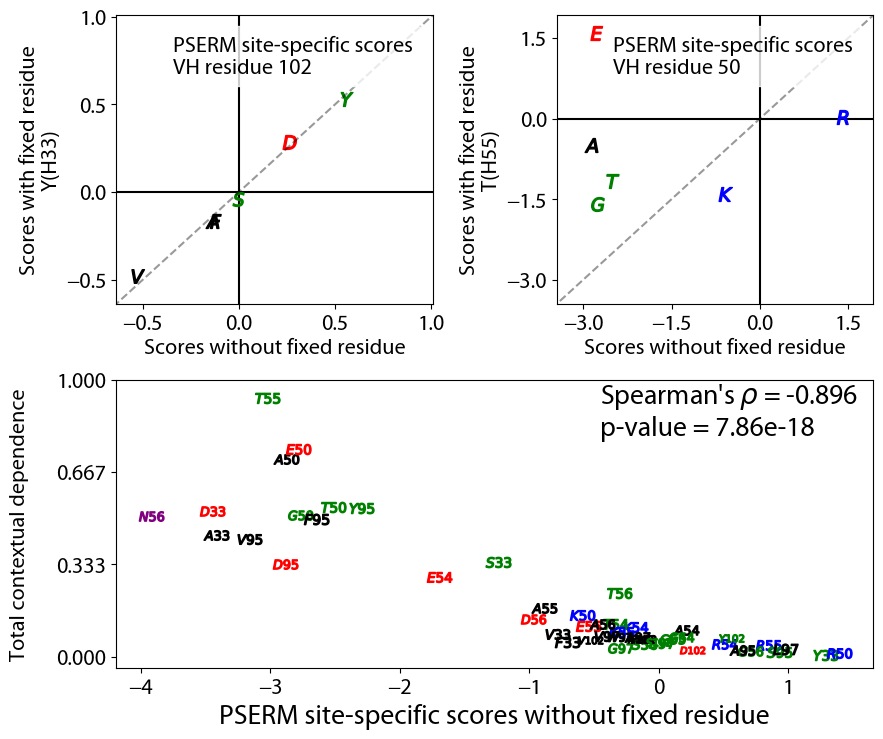

In [9]:
corr_loc = (-.45, 0.8)

plots = {
    0: [7, '0_Y', 'Scores with fixed residue\nY(H33)'],
    1: [1, '3_T', 'Scores with fixed residue\nT(H55)']
}

create_contextual_dependence(
    ngs_analysis = p1_data, sample = 'Ag01_P', plots_data = plots, corr_loc = corr_loc, 
    fname = 'Fig 6. Contextual Preference.pdf', 
    mut_pos=['33', '50', '54', '55', '56', '95', '97', '102'], 
    reagent = 'Ag01_P')

bdat NOT subset; don't know how to subset; dropped
bloc NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


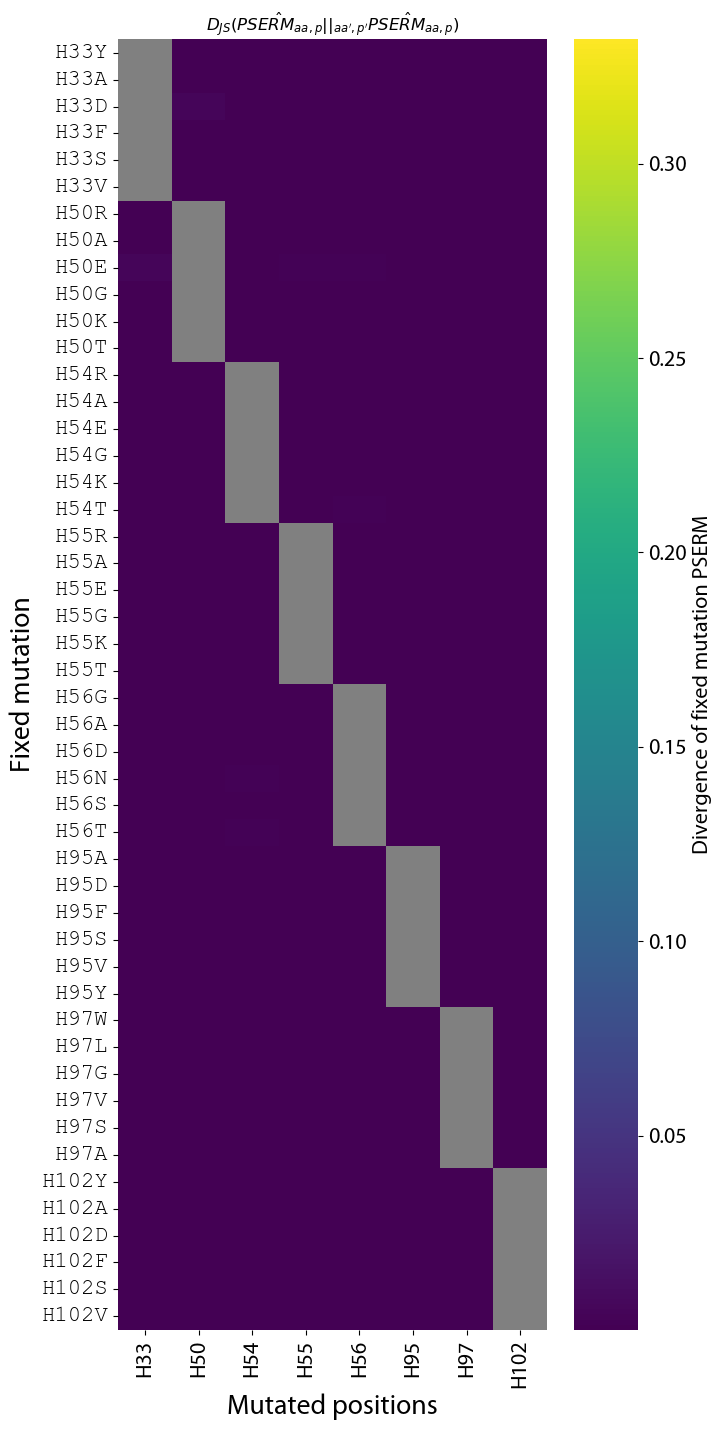

In [19]:
fig, ax = plt.subplots(figsize = (7.2 , 7.2 * 2))
############# Plot Heatmap of DJS ####################
ag_mask = np.zeros_like(p1_data.JS_data['Ova_P'])
row = 0
for j in range(len(p1_data.wt)):
    for _ in range(len(p1_data.library[j])):
        ag_mask[row, j] = 1
        row += 1

#set ylim to ag01_P min and max to show how little context matters for Ova
cmin = p1_data.JS_data['Ag01_P'].min().min()
cmax = p1_data.JS_data['Ag01_P'].max().max()

sns.heatmap(p1_data.JS_data['Ova_P'], mask = ag_mask, ax = ax, cmap = 'viridis', vmin = cmin, vmax = cmax)
ax.set_facecolor('grey')

mutated_pos = ['H33', 'H50', 'H54', 'H55', 'H56', 'H95', 'H97', 'H102']

current_yticks = ax.get_yticklabels()
new_yticks = [
    f"{mutated_pos[int(t.get_text().split('_')[0])]}{t.get_text().split('_')[1]}" for t in current_yticks]

ax.set_xlabel('Mutated positions', fontproperties = prop)
ax.set_ylabel('Fixed mutation', fontproperties = prop)
ax.set_yticklabels(new_yticks)

ax.set_xticks([i + 0.5 for i in range(len(mutated_pos))], mutated_pos, fontproperties = tickprop, rotation = 90)

for tick in ax.get_yticklabels():
    tick.set_fontproperties(aaprop)
    tick.set_rotation(0)

cbar_label = r"Divergence of fixed mutation PSERM" 
ax_title = r"$\hat{D_{JS}(PSERM_{aa,p}}||\hat{_{aa',p'}PSERM_{aa,p}})$"

colorbar = ax.collections[0].colorbar
colorbar.set_label(cbar_label, fontproperties = tickprop)

for tick in colorbar.ax.get_yticklabels():
    tick.set_fontproperties(tickprop)
ax.set_title(ax_title)

plt.tight_layout()
plt.savefig('Fig S3 All mutations Ova JS divergence.pdf')
plt.show()

bdat NOT subset; don't know how to subset; dropped
bloc NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


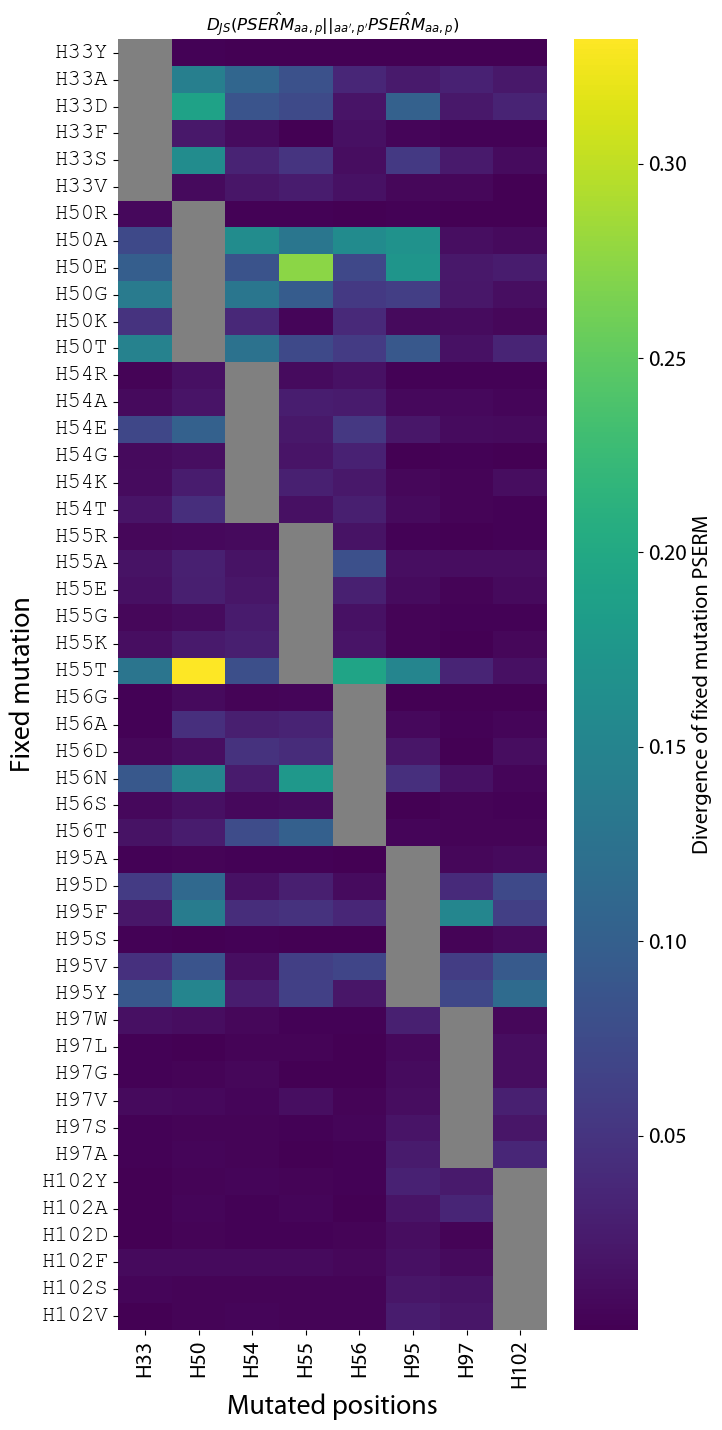

In [18]:
fig, ax = plt.subplots(figsize = (7.2 , 7.2 * 2))
############# Plot Heatmap of DJS ####################
ag_mask = np.zeros_like(p1_data.JS_data['Ag01_P'])
row = 0
for j in range(len(p1_data.wt)):
    for _ in range(len(p1_data.library[j])):
        ag_mask[row, j] = 1
        row += 1

#set ylim to ag01_P min and max to show how little context matters for Ova
cmin = p1_data.JS_data['Ag01_P'].min().min()
cmax = p1_data.JS_data['Ag01_P'].max().max()

sns.heatmap(p1_data.JS_data['Ag01_P'], mask = ag_mask, ax = ax, cmap = 'viridis', vmin = cmin, vmax = cmax)
ax.set_facecolor('grey')

mutated_pos = ['H33', 'H50', 'H54', 'H55', 'H56', 'H95', 'H97', 'H102']

current_yticks = ax.get_yticklabels()
new_yticks = [
    f"{mutated_pos[int(t.get_text().split('_')[0])]}{t.get_text().split('_')[1]}" for t in current_yticks]

ax.set_xlabel('Mutated positions', fontproperties = prop)
ax.set_ylabel('Fixed mutation', fontproperties = prop)
ax.set_yticklabels(new_yticks)

ax.set_xticks([i + 0.5 for i in range(len(mutated_pos))], mutated_pos, fontproperties = tickprop, rotation = 90)

for tick in ax.get_yticklabels():
    tick.set_fontproperties(aaprop)
    tick.set_rotation(0)

cbar_label = r"Divergence of fixed mutation PSERM" 
ax_title = r"$\hat{D_{JS}(PSERM_{aa,p}}||\hat{_{aa',p'}PSERM_{aa,p}})$"

colorbar = ax.collections[0].colorbar
colorbar.set_label(cbar_label, fontproperties = tickprop)

for tick in colorbar.ax.get_yticklabels():
    tick.set_fontproperties(tickprop)
ax.set_title(ax_title)

plt.tight_layout()
plt.savefig('Fig S3 All mutations Ag JS divergence.pdf')
plt.show()